In [ ]:
# Import modules and setup notebook

%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble, metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam


# kappa metric for measuring agreement of automatic to human scores
# from skll.metrics import kappa
# from bhkappa import mean_quadratic_weighted_kappa

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [ ]:
pip install language_tool_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read essays from training_set
df_all  = pd.read_csv('/content/drive/MyDrive/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})

df_all.head(5)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_pickle('/content/drive/My Drive/df_feature.pkl')

In [ ]:
df.head()

,Score,weights_uncommon,pct_transitions,transition_word,grammar_chk,grammar_error,determiners,conjunctions,prn_density,prn_noun_ratio,n_trigram_lemma_types,n_bigram_lemma_types,nlemma_types,nlemmas,n_bigram_lemmas,n_trigram_lemmas,ncontent_tokens,ncontent_types,content_ttr,nfunction_tokens,nfunction_types,function_ttr,noun_ttr,fre,fkg,cli,ari,dcrs,dw,lwf,gf,num_tokens,num_types,avg_len_word,num_sents,avg_len_sent,num_syllab,num_chars,sent_density,ttr,english_usage,pct_rel_trigrams,essay
0,8,0.000160,0.0374,now,0.04571,... ever time to chat with your friends or buisness partner about things. Well now - there'...,0.05714,0.01429,0.02857,0.34,164,165,166,350,349,348,177,110,0.6215,173,56,0.3237,0.7241,74.02,8.5,8.54,11.3,7.00,28,8.666667,10.31,350,166,4.2371,16,22.5,445,1538,4.57,47.43,132,26.89,"Dear local newspaper, I think effects computers have on people are great learning skills/affects..."
1,9,0.000139,0.0280,never,0.05910,"...ysace. Using computers can help us find coordibates, locations, and able ourselfs to millio...",0.08274,0.03546,0.02128,0.15,194,195,196,423,422,421,238,136,0.5714,185,60,0.3243,0.5254,67.08,9.1,7.95,10.1,7.28,51,10.166667,10.21,423,196,4.3121,20,21.0,585,1870,4.73,46.34,146,38.66,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and..."
2,7,0.000133,0.0093,then,0.06007,... for the fun of it. Computers is one of mans greatest accomplishments. Computers are...,0.09541,0.05300,0.01767,0.11,149,150,151,283,282,281,147,97,0.6599,136,54,0.3971,0.6383,68.20,8.7,8.30,9.9,7.62,37,8.142857,10.25,283,151,4.3428,14,19.9,399,1263,4.95,53.36,119,29.41,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this..."
3,10,0.000278,0.0280,then,0.05472,"...around the world. Computers help people reaserch subjects for school reports, and they m...",0.08113,0.01698,0.02453,0.10,249,250,251,530,529,528,318,193,0.6069,212,58,0.2736,0.5161,60.24,9.7,10.97,12.0,8.34,98,7.857143,10.81,530,251,4.8132,27,19.4,805,2642,5.09,47.36,170,38.66,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou..."
4,8,0.000160,0.0374,now,0.03594,"...eat for peoples education, and are very conveint. Computors are a step into the future a...",0.11416,0.02537,0.02114,0.20,199,200,201,473,472,471,249,134,0.5382,224,67,0.2991,0.6200,72.66,7.0,8.00,7.7,6.51,47,8.428571,8.01,473,201,4.3340,30,15.5,660,2105,6.34,42.49,158,38.66,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ..."


In [ ]:
df2 = pd.read_pickle('/content/drive/My Drive/Training_Features.pkl')

In [ ]:
df2.head()

,essay_id,topic,essay,target_score,word_count,matches,corrections_len,corrected,tokens,lemma,pos,sents,ner,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,location,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj,avg_len_words,difficult_count,weights_uncommon
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",8,338,"[Offset 218, length 6, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",16,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...","[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[dear, local, newspaper, ,, I, think, effect, computer, have, on, people, be, great, learning, s...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, AUX, ADP, NOUN, AUX, ADJ, NOUN, NOUN, SYM, NOUN,...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[@ORGANIZATION2, @CAPS1, Facebook, @CAPS2]",395,180,203,16,4,18,3,4,7,0,79,18,47,51,14,15,21,3,0,16,2,3.984536,2,0.000160
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",9,419,"[Offset 148, length 8, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",25,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...","[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[dear, @CAPS1, @caps2, ,, I, believe, that, use, computer, will, benefit, we, in, many, way, lik...","[ADJ, NOUN, ADV, PUNCT, PRON, VERB, SCONJ, VERB, NOUN, AUX, VERB, PRON, ADP, ADJ, NOUN, ADP, VER...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[@CAPS1, millions, one, Facebook, one, millions, @LOCATION3, @LOCATION2, Million, millions, one]",459,206,240,20,11,16,3,1,5,3,93,23,51,71,18,17,29,9,4,10,0,3.991471,9,0.000139
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",7,279,"[Offset 315, length 4, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found....",17,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...","[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[dear, ,, @CAPS1, @caps2, @CAPS3, More, and, more, people, use, computer, ,, but, not, everyone,...","[ADJ, PUNCT, PROPN, ADV, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, PART, PRON, VER...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, @CAPS4, one, a thousand]",311,163,158,14,4,13,0,0,5,0,70,19,26,38,16,13,26,5,3,10,0,4.012658,7,0.000133
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",10,524,"[Offset 86, length 7, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake found.\...",29,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benefit ou...","[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[Dear, Local, Newspaper, ,, @CAPS1, I, have, find, that, many, expert, say, that, computer, do, ...","[PROPN, PROPN, PROPN, PUNCT, PROPN, PRON, AUX, VERB, SCONJ, ADJ, NOUN, VERB, SCONJ, NOUN, AUX, P...","[Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benefit o...","[@CAPS1, @PERSON1, @PERSON2, @CAPS3, @PERCENT2, @PERCENT2, A+, @CAPS7, @CAPS2, Newspaper, Newspa...",577,264,331,27,15,14,1,2,6,3,134,40,32,73,17,21,43,35,0,23,0,4.315359,7,0.000278
4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",8,465,"[Offset 177, length 8, Rule ID: MORFOLOGIK_RULE_EN_US

In [ ]:
df['topic'] = df2['topic']

In [ ]:
df.head()

,Score,weights_uncommon,pct_transitions,transition_word,grammar_chk,grammar_error,determiners,conjunctions,prn_density,prn_noun_ratio,n_trigram_lemma_types,n_bigram_lemma_types,nlemma_types,nlemmas,n_bigram_lemmas,n_trigram_lemmas,ncontent_tokens,ncontent_types,content_ttr,nfunction_tokens,nfunction_types,function_ttr,noun_ttr,fre,fkg,cli,ari,dcrs,dw,lwf,gf,num_tokens,num_types,avg_len_word,num_sents,avg_len_sent,num_syllab,num_chars,sent_density,ttr,english_usage,pct_rel_trigrams,essay,topic
0,8,0.000160,0.0374,now,0.04571,... ever time to chat with your friends or buisness partner about things. Well now - there'...,0.05714,0.01429,0.02857,0.34,164,165,166,350,349,348,177,110,0.6215,173,56,0.3237,0.7241,74.02,8.5,8.54,11.3,7.00,28,8.666667,10.31,350,166,4.2371,16,22.5,445,1538,4.57,47.43,132,26.89,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",1
1,9,0.000139,0.0280,never,0.05910,"...ysace. Using computers can help us find coordibates, locations, and able ourselfs to millio...",0.08274,0.03546,0.02128,0.15,194,195,196,423,422,421,238,136,0.5714,185,60,0.3243,0.5254,67.08,9.1,7.95,10.1,7.28,51,10.166667,10.21,423,196,4.3121,20,21.0,585,1870,4.73,46.34,146,38.66,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",1
2,7,0.000133,0.0093,then,0.06007,... for the fun of it. Computers is one of mans greatest accomplishments. Computers are...,0.09541,0.05300,0.01767,0.11,149,150,151,283,282,281,147,97,0.6599,136,54,0.3971,0.6383,68.20,8.7,8.30,9.9,7.62,37,8.142857,10.25,283,151,4.3428,14,19.9,399,1263,4.95,53.36,119,29.41,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",1
3,10,0.000278,0.0280,then,0.05472,"...around the world. Computers help people reaserch subjects for school reports, and they m...",0.08113,0.01698,0.02453,0.10,249,250,251,530,529,528,318,193,0.6069,212,58,0.2736,0.5161,60.24,9.7,10.97,12.0,8.34,98,7.857143,10.81,530,251,4.8132,27,19.4,805,2642,5.09,47.36,170,38.66,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",1
4,8,0.000160,0.0374,now,0.03594,"...eat for peoples education, and are very conveint. Computors are a step into the future a...",0.11416,0.02537,0.02114,0.20,199,200,201,473,472,471,249,134,0.5382,224,67,0.2991,0.6200,72.66,7.0,8.00,7.7,6.51,47,8.428571,8.01,473,201,4.3340,30,15.5,660,2105,6.34,42.49,158,38.66,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",1


In [ ]:
feature_list = ['weights_uncommon','pct_transitions','grammar_chk','determiners', 'conjunctions', 'prn_density', 'prn_noun_ratio', 'n_trigram_lemma_types', 'n_bigram_lemma_types', 'nlemma_types', 'nlemmas', 'n_bigram_lemmas', 'n_trigram_lemmas', 'ncontent_tokens', 'ncontent_types', 'content_ttr', 'nfunction_tokens', 'nfunction_types', 'function_ttr', 'noun_ttr', 'fre', 'fkg', 'cli', 'ari', 'dcrs', 'dw', 'lwf', 'gf', 'num_tokens', 'num_types', 'avg_len_word', 'num_sents', 'avg_len_sent', 'num_syllab', 'num_chars', 'sent_density', 'ttr', 'english_usage', 'pct_rel_trigrams']
predictors = feature_list

In [ ]:
selector = SelectKBest(f_regression, k=20) # f_classif, chi2, f_regression, mutual_info_classif, mutual_info_regression

# Create empty dataframe
df3 = pd.DataFrame()

for topic in range(1, 9):
    kpredictors = []

    # test for division by zero errors due to insufficient data:
    for p in predictors:
        if np.std(df[df.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)

    # select k best for each topic:
    X = df[df.topic == topic][kpredictors]
    y = df[df.topic == topic].Score

    selector.fit(X, y)

    # Get idxs of columns to keepp
    mask = selector.get_support(indices=True)

    selected_features = df[df.topic == topic][predictors].columns[mask]
    df3["Topic " + str(topic)] = selected_features
df3

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,weights_uncommon,grammar_chk,weights_uncommon,n_trigram_lemma_types,n_trigram_lemma_types,weights_uncommon,pct_transitions,weights_uncommon
1,n_trigram_lemma_types,n_trigram_lemma_types,n_trigram_lemma_types,n_bigram_lemma_types,n_bigram_lemma_types,n_trigram_lemma_types,n_trigram_lemma_types,pct_transitions
2,n_bigram_lemma_types,n_bigram_lemma_types,n_bigram_lemma_types,nlemma_types,nlemma_types,n_bigram_lemma_types,n_bigram_lemma_types,grammar_chk
3,nlemma_types,nlemma_types,nlemma_types,nlemmas,nlemmas,nlemma_types,nlemma_types,n_trigram_lemma_types
4,nlemmas,nlemmas,nlemmas,n_bigram_lemmas,n_bigram_lemmas,nlemmas,nlemmas,n_bigram_lemma_types
5,n_bigram_lemmas,n_bigram_lemmas,n_bigram_lemmas,n_trigram_lemmas,n_trigram_lemmas,n_bigram_lemmas,n_bigram_lemmas,nlemma_types
6,n_trigram_lemmas,n_trigram_lemmas,n_trigram_lemmas,ncontent_tokens,ncontent_tokens,n_trigram_lemmas,n_trigram_lemmas,nlemmas
7,ncontent_tokens,ncontent_tokens,ncontent_tokens,ncontent_types,ncontent_types,ncontent_tokens,ncontent_tokens,n_bigram_lemmas
8,ncontent_types,ncontent_types,ncontent_types,nfunction_tokens,nfunction_tokens,ncontent_types,ncontent_types,n_trigram_lemmas
9,nfunction_tokens,nfunction_tokens,nfunction_tokens,nfunction_types,nfunction_types,nfunction_tokens,nfunction_tokens,ncontent_tokens


In [ ]:
def evaluate_model(model ,X_train ,X_test ,y_train ,y_test):
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    train_mae = mean_absolute_error(y_train, train_y_pred)
    train_mse = mean_squared_error(y_train, train_y_pred)
    train_rmse= np.sqrt(train_mse)
    train_r2 = r2_score(y_train,train_y_pred)
    test_mae = mean_absolute_error(y_test, test_y_pred)
    test_mse = mean_squared_error(y_test, test_y_pred)
    test_rmse= np.sqrt(test_mse)
    test_r2 = r2_score(y_test,test_y_pred)

    report = f'----------\nTrain MAE : {train_mae} ,Train MSE : {train_mse} ,Train RMSE : {train_rmse},Train R2 : {train_r2}\nTest MAE : {test_mae} ,Test MSE : {test_mse} ,Test R2: {test_r2} ,Test RMSE : {test_rmse}\n----------'
    return report ,train_y_pred ,test_y_pred

In [ ]:
from sklearn import ensemble, metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

for topic in range(1, 9):
    kpredictors = []
    print("Topic :",topic)
    # test for division by zero errors due to insufficient data:
    for p in predictors:
        if np.std(df[df.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)

    # select k best for each topic:
    X = df[df.topic == topic][kpredictors]
    y = df[df.topic == topic].final_score2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    model = ensemble.GradientBoostingRegressor(
       n_estimators=500,
       learning_rate=0.01,
       max_depth=6,
       min_samples_leaf=17,
       max_features=0.1,
       loss='ls',
       random_state=0
    )
    model.fit(X_train, y_train)
    print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

Topic : 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.20707135214797476 ,Train MSE : 0.07264150906666177 ,Train RMSE : 0.269520887996945,Train R2 : 0.8772289480239879
Test MAE : 0.3124802096754115 ,Test MSE : 0.16400444297271058 ,Test R2: 0.7213455108023852 ,Test RMSE : 0.40497462015873364
----------
Topic : 2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.2750301804765877 ,Train MSE : 0.12827259995418833 ,Train RMSE : 0.35815164379657444,Train R2 : 0.7848426634268268
Test MAE : 0.38108974983641175 ,Test MSE : 0.23673786747169648 ,Test R2: 0.6195284272776307 ,Test RMSE : 0.4865571574560346
----------
Topic : 3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.5200497109565866 ,Train MSE : 0.4661601349723139 ,Train RMSE : 0.6827592071677349,Train R2 : 0.7460830568416608
Test MAE : 0.7223666459181839 ,Test MSE : 0.934339834158321 ,Test R2: 0.5113586796064081 ,Test RMSE : 0.9666125563835394
----------
Topic : 4


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.582176726290473 ,Train MSE : 0.5331578173227078 ,Train RMSE : 0.7301765658542514,Train R2 : 0.7826891968793658
Test MAE : 0.7438924058907342 ,Test MSE : 0.8710405492555862 ,Test R2: 0.6427644155510484 ,Test RMSE : 0.9332955315737809
----------
Topic : 5


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.36175678390239296 ,Train MSE : 0.2121159049983297 ,Train RMSE : 0.4605604249154824,Train R2 : 0.8546062734464344
Test MAE : 0.521029838156444 ,Test MSE : 0.43904525745584716 ,Test R2: 0.7234761347285357 ,Test RMSE : 0.6626049029820464
----------
Topic : 6


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.44726567110405924 ,Train MSE : 0.335645483162051 ,Train RMSE : 0.5793491893168152,Train R2 : 0.7698258067565369
Test MAE : 0.6683551964867033 ,Test MSE : 0.693666745505201 ,Test R2: 0.563278065496847 ,Test RMSE : 0.8328665832564067
----------
Topic : 7


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.2568145991989158 ,Train MSE : 0.10735785932394666 ,Train RMSE : 0.3276550920158981,Train R2 : 0.8185700946132856
Test MAE : 0.3600740105734851 ,Test MSE : 0.2045942895617921 ,Test R2: 0.5992459335951833 ,Test RMSE : 0.4523210027865079
----------
Topic : 8


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.15608500810994294 ,Train MSE : 0.04086164861364487 ,Train RMSE : 0.20214264422344155,Train R2 : 0.8238658276785769
Test MAE : 0.24080654120849743 ,Test MSE : 0.09099148506795225 ,Test R2: 0.5621728000658082 ,Test RMSE : 0.3016479488873615
----------


In [ ]:
min_range = [2,1,0,0,0,0,0,0]
max_range = [12,6,3,3,4,4,30,60]
def normalize(x,mi,ma):
    # x = (x-mi)/(ma-mi)
    return 0 + (x - mi) * (5 - 0) / (ma - mi)
df['final_score2']=df.apply(lambda x:normalize(x['Score'],min_range[x['topic']-1],max_range[x['topic']-1]),axis=1)

In [ ]:
from sklearn import ensemble, metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
X_train = df[df.topic == 5][predictors]
y_train = df[df.topic == 5].final_score2
X_test = df[df.topic == 6][predictors]
y_test = df[df.topic == 6].final_score2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# pca = PCA()
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
model = ensemble.GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split =5,
    max_features=0.1,
    loss='ls',
    random_state=0
)
model.fit(X_train, y_train)
print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.30509792880132414 ,Train MSE : 0.15132268790380182 ,Train RMSE : 0.3890021695361117,Train R2 : 0.897187396613393
Test MAE : 0.690834928791996 ,Test MSE : 0.7602431476542897 ,Test R2: 0.4832671893598711 ,Test RMSE : 0.8719192322998098
----------


In [ ]:
parameters = {'learning_rate': [0.01,0.03,0.05],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [200,500,1000],
              'max_depth'    : [4,6,8,10]
              }
GBR = ensemble.GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [200, 500, 1000],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [ ]:
print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

----------
Train MAE : 0.30509792880132414 ,Train MSE : 0.15132268790380182 ,Train RMSE : 0.3890021695361117,Train R2 : 0.897187396613393
Test MAE : 0.690834928791996 ,Test MSE : 0.7602431476542897 ,Test R2: 0.4832671893598711 ,Test RMSE : 0.8719192322998098
----------


In [ ]:
X = df[df.topic == 5][predictors]
y = df[df.topic == 5].final_score2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
model = ensemble.GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=2,
    min_samples_leaf=10,
    max_features=10,
    loss='ls',
    random_state=0
)
model.fit(X_train, y_train)
print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.438778764441685 ,Train MSE : 0.31243727742057914 ,Train RMSE : 0.5589608907791127,Train R2 : 0.7839369852426854
Test MAE : 0.49912754107687224 ,Test MSE : 0.4018590972757034 ,Test R2: 0.7448172397615241 ,Test RMSE : 0.6339235736866893
----------


In [ ]:
# X = df[df.topic == 5][predictors]
# y = df[df.topic == 5].Score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
estimator = xgb.XGBRegressor(
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 200, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_samples_split' :[2,4,8],
    'min_samples_leaf': [0.1, 1, 5]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[10:16:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'min_samples_leaf': [0.1, 1, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': range(100, 200, 50)},
             scoring='r2', verbose=True)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=0.1,
             min_samples_split=2, n_estimators=150)

 The best score across ALL searched params:
 0.5508018131759288

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
estimator = xgb.XGBRegressor(**grid_search.best_params_)
estimator.fit(X_train,y_train)
print(evaluate_model(estimator ,X_train ,X_test ,y_train ,y_test)[0])

[10:19:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------
Train MAE : 0.5125053628264672 ,Train MSE : 0.4517696641093315 ,Train RMSE : 0.6721381287423973,Train R2 : 0.670658061241272
Test MAE : 0.5867063777686757 ,Test MSE : 0.5774280068576952 ,Test R2: 0.5788907367029106 ,Test RMSE : 0.7598868381921714
----------


In [ ]:
from sklearn.preprocessing import PolynomialFeatures


X = df[df.topic == 5][predictors]
y = df[df.topic == 5].final_score2
poly = PolynomialFeatures(degree=3)

X_F1_poly = poly.fit_transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_F1_poly, y,
                                                   random_state = 0)

In [ ]:
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)
model = ensemble.GradientBoostingRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=2,
    min_samples_leaf=2,
    max_features=20,
    loss='ls',
    random_state=0
)
model.fit(X_train1, y_train1)
print(evaluate_model(model ,X_train1 ,X_test1 ,y_train1 ,y_test1)[0])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


----------
Train MAE : 0.4042824885638736 ,Train MSE : 0.26737673881430224 ,Train RMSE : 0.5170848468233258,Train R2 : 0.8123256747719906
Test MAE : 0.4923774622954852 ,Test MSE : 0.399609717394784 ,Test R2: 0.7521685855577932 ,Test RMSE : 0.6321469112435685
----------


In [ ]:
y

7079    2.50
7080    2.50
7081    3.75
7082    1.25
7083    3.75
        ... 
8879    2.50
8880    0.00
8881    5.00
8882    3.75
8883    2.50
Name: final_score2, Length: 1805, dtype: float64

In [ ]:
X = df[df.topic == 5][predictors]
y = df[df.topic == 5].final_score2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
estimator = xgb.XGBRegressor(
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 200, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_samples_split' :[2,4,8],
    'min_samples_leaf': [0.1, 1, 5]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[14:00:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'min_samples_leaf': [0.1, 1, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': range(100, 200, 50)},
             scoring='r2', verbose=True)

In [ ]:
poly = PolynomialFeatures(degree=2)
X = df[df.topic == 5][predictors]
y = df[df.topic == 5].final_score2
X_F1_poly = poly.fit_transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_F1_poly, y,test_size = 0.2,
                                                   random_state = 0)
grid_search.fit(X_train1, y_train1)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
X = df[predictors]
y = df.final_score2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=True)
model = Sequential()
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mean_squared_error')

In [ ]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=32,
          epochs=20)
model.summary()

Epoch 1/20
325/325 [==============================] - 1s 3ms/step - loss: 0.9071 - val_loss: 0.7548
Epoch 2/20
325/325 [==============================] - 1s 2ms/step - loss: 0.9274 - val_loss: 0.7835
Epoch 3/20
325/325 [==============================] - 1s 2ms/step - loss: 0.8602 - val_loss: 1.0788
Epoch 4/20
325/325 [==============================] - 1s 2ms/step - loss: 0.9473 - val_loss: 0.7650
Epoch 5/20
325/325 [==============================] - 1s 2ms/step - loss: 0.9339 - val_loss: 1.3454
Epoch 6/20
325/325 [==============================] - 1s 2ms/step - loss: 0.9139 - val_loss: 0.7484
Epoch 7/20
325/325 [==============================] - 1s 2ms/step - loss: 0.8847 - val_loss: 0.7554
Epoch 8/20
325/325 [==============================] - 1s 2ms/step - loss: 0.9232 - val_loss: 0.8126
Epoch 9/20
325/325 [==============================] - 1s 2ms/step - loss: 0.8879 - val_loss: 0.8745
Epoch 10/20
325/325 [==============================] - 1s 2ms/step - loss: 0.8956 - val_loss: 0.7698

In [ ]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
train_score = model.evaluate(X_train, y_train, verbose=0)
valid_score = model.evaluate(X_test, y_test, verbose=0)

print('Train MAE: ', round(train_score, 4), ', Train Loss: ', round(train_score, 4))
print('Val MAE: ', round(valid_score, 4), ', Val Loss: ', round(valid_score, 4))
print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

MAE: 0.6293306487703789
MSE: 0.6541739520146047
RMSE: 0.808810207659748
Train MAE:  0.6701 , Train Loss:  0.6701
Val MAE:  0.6542 , Val Loss:  0.6542
----------
Train MAE : 0.6286345846965363 ,Train MSE : 0.6700861052627725 ,Train RMSE : 0.8185878726580137,Train R2 : 0.5115044798822113
Test MAE : 0.6293306487703789 ,Test MSE : 0.6541739520146047 ,Test R2: 0.5229211127112746 ,Test RMSE : 0.808810207659748
----------


In [ ]:
keras_callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]
history = model.fit(X_train, y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(X_test, y_test),
    )

In [ ]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)

    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

In [ ]:
from keras.callbacks import EarlyStopping

X = df[predictors]
y = df.final_score2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=True)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
earlystop = EarlyStopping(monitor = 'val_loss',

mode= 'min', patience = 50, verbose = 1,

restore_best_weights = True,

min_delta = 0.001)
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=10, input_dim=39, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
# The output neuron is a single fully connected node
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
# model.compile(loss='mean_squared_error', optimizer='adam')
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])


# Fitting the ANN to the Training set
estimator = model.fit(X_train, y_train,validation_data=(X_test,y_test) ,batch_size = 40, epochs = 500,callbacks=[earlystop])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


260/260 [==============================] - 3s 7ms/step - loss: 6.1358 - mse: 6.1358 - mae: 2.1084 - val_loss: 2.0709 - val_mse: 2.0709 - val_mae: 1.1402
Epoch 2/500
260/260 [==============================] - 2s 6ms/step - loss: 1.5461 - mse: 1.5461 - mae: 0.9636 - val_loss: 1.2610 - val_mse: 1.2610 - val_mae: 0.8719
Epoch 3/500
260/260 [==============================] - 1s 6ms/step - loss: 1.1578 - mse: 1.1578 - mae: 0.8349 - val_loss: 1.1021 - val_mse: 1.1021 - val_mae: 0.8206
Epoch 4/500
260/260 [==============================] - 1s 6ms/step - loss: 1.0512 - mse: 1.0512 - mae: 0.8003 - val_loss: 1.0088 - val_mse: 1.0088 - val_mae: 0.7856
Epoch 5/500
260/260 [==============================] - 1s 5ms/step - loss: 0.9231 - mse: 0.9231 - mae: 0.7467 - val_loss: 0.8276 - val_mse: 0.8276 - val_mae: 0.7050
Epoch 6/500
260/260 [==============================] - 1s 5ms/step - loss: 0.7928 - mse: 0.7928 - mae: 0.6857 - val_loss: 0.7378 - val_mse: 0.7378 - val_mae: 0.6639
Epoch 7/500
260/260 [=

{'loss': [6.135846138000488, 1.546063780784607, 1.157762885093689, 1.051159143447876, 0.9230982661247253, 0.7927863001823425, 0.7444958686828613, 0.7198172807693481, 0.7015629410743713, 0.6887640953063965, 0.676014244556427, 0.6630383729934692, 0.6529725193977356, 0.6401325464248657, 0.6326068043708801, 0.6260818243026733, 0.6202303171157837, 0.6133018136024475, 0.6084715127944946, 0.6044090390205383, 0.6017797589302063, 0.598588764667511, 0.5978260040283203, 0.5950283408164978, 0.5905649065971375, 0.5901230573654175, 0.5893094539642334, 0.5857570767402649, 0.5847407579421997, 0.5850147008895874, 0.5831855535507202, 0.5818465948104858, 0.5822118520736694, 0.5791086554527283, 0.5791125893592834, 0.5785394906997681, 0.576613187789917, 0.575097918510437, 0.5754790306091309, 0.5743868350982666, 0.5729876756668091, 0.5727807879447937, 0.570955753326416, 0.5723654627799988, 0.5701421499252319, 0.5694128274917603, 0.5690308809280396, 0.5676456689834595, 0.5675126314163208, 0.5670973658561707,

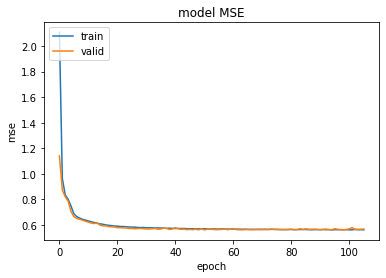

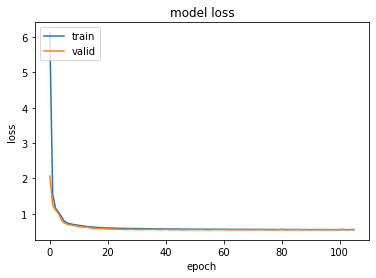

In [ ]:
"""
Use this for plotting regression mean-squared error
Validation split must be enabled during model fit.
"""
# Plot model mse over epochs
print(estimator.history)
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['mae'])
plt.plot(estimator.history['val_mae'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.ylim(0,300)
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
train_score = model.evaluate(X_train, y_train, verbose=0)
valid_score = model.evaluate(X_test, y_test, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))
print(evaluate_model(model ,X_train ,X_test ,y_train ,y_test)[0])

MAE: 0.5627869632445242
MSE: 0.5465759665935338
RMSE: 0.7393077617565866
Train MAE:  0.5584 , Train Loss:  0.5584
Val MAE:  0.5466 , Val Loss:  0.5466
----------
Train MAE : 0.5637667417497534 ,Train MSE : 0.5584330307701845 ,Train RMSE : 0.7472837685713403,Train R2 : 0.5929000293028615
Test MAE : 0.5627869632445242 ,Test MSE : 0.5465759665935338 ,Test R2: 0.6013906497527723 ,Test RMSE : 0.7393077617565866
----------


In [ ]:
def outliers(df_data,var):
    a = []
    q1 =  df_data[var].quantile(.25)
    q2 =  df_data[var].quantile(.5)
    q3 =  df_data[var].quantile(.75)
    iqr = q3-q1
    ulim = float(q3+(2*iqr))
    llim = float(q1-(2*iqr))

    for i in  df_data[var]:
        if i > ulim:
            i=np.NaN
        elif i < llim:
            i = np.NaN
        else:
            i=i
        a.append(i)
    return a

for col in  X.columns:
     X[col] = outliers(X,col)

X.isna().sum()

X.isna().sum().sum()

for i in X.columns:
  X[i]=X[i].fillna(X[i].std())
  X.isna().sum().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from sentence_similarity import sentence_similarity

model=sentence_similarity(model_name='distilbert-base-uncased',embedding_type='cls_token_embedding')


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:

sentence_a = "I think that reading and writing is more important now than in the past"
sentence_b = "This is a really grate country and I'm glad to live here"
score=model.get_score(sentence_a,sentence_b,metric="cosine")
print(score)

401 Client Error: Unauthorized for url: https://huggingface.co/all-MiniLM-L6-v2/resolve/main/config.json


OSError: ignored

In [ ]:
pip install sentence_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 1.2 MB 38.3 MB/s 
     |████████████████████████████████| 101 kB 9.9 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
     |████████████████████████████████| 3.3 MB 39.8 MB/s 
     |████████████████████████████████| 880 kB 29.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=f93e0e4d0b0c769983b361b41c95a7880502079174e5e3a7cce9b8af18964535
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=642e1db0b9bb87de783972a1fc1f9a72d3c75b928f5b4dcbed4bf52d71e30d5d
  Stored in directory: /root/.cache/pip/wheels/87/3

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[[ 6.76569417e-02  6.34960085e-02  4.87131625e-02  7.93049410e-02
   3.74480858e-02  2.65283487e-03  3.93749997e-02 -7.09846290e-03
   5.93614094e-02  3.15369666e-02  6.00980744e-02 -5.29052280e-02
   4.06067707e-02 -2.59308703e-02  2.98428256e-02  1.12688239e-03
   7.35148713e-02 -5.03819063e-02 -1.22386619e-01  2.37028785e-02
   2.97265593e-02  4.24768329e-02  2.56337505e-02  1.99517841e-03
  -5.69190383e-02 -2.71597970e-02 -3.29035111e-02  6.60248771e-02
   1.19007193e-01 -4.58790921e-02 -7.26214126e-02 -3.25840227e-02
   5.23413047e-02  4.50553037e-02  8.25307053e-03  3.67024168e-02
  -1.39415748e-02  6.53918162e-02 -2.64272206e-02  2.06408804e-04
  -1.36643089e-02 -3.62810753e-02 -1.95043404e-02 -2.89737899e-02
   3.94269899e-02 -8.84090587e-02  2.62428867e-03  1.36713544e-02
   4.83062752e-02 -3.11566070e-02 -1.17329173e-01 -5.11690155e-02
  -8.85287598e-02 -2.18963567e-02  1.42986383e-02  4.44167741e-02
  -1.34815723e-02  7.43392333e-02  2.66382582e-02 -1.98762715e-02
   1.79191

In [ ]:
pip install -U sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.3 MB/s 
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
     |████████████████████████████████| 4.4 MB 18.1 MB/s 
     |████████████████████████████████| 6.6 MB 23.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=08338d53309cfd3c3a26d7b24c325566ba8d9aac65e4deade452d8114d28e95e
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.12
    Uninstalling huggingface-hub-0.0.12:
      Successfully uninstalle

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
target_sentence = "I think that reading and writing is more important now than in the past"

sentences = [
    "This is a really grate country and I'm glad to live here"
]
embedding = list()
for index in range(len(sentences)):
    embedding.append(model.encode(sentences[index], convert_to_tensor = True))

target_embedding = model.encode(target_sentence, convert_to_tensor = True)

In [ ]:
for index in range(len(embedding)):
    cos_similarity = util.pytorch_cos_sim(target_embedding, embedding[index]).numpy()
    print(f'Similarity score between {target_sentence} and {sentences[index]} is', cos_similarity[0][0])

Similarity score between I think that reading and writing is more important now than in the past and This is a really grate country and I'm glad to live here is 0.112350464


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
import string
import statistics
def measure_simmilarity(essay):
  doc = nlp(essay)
  l=0
  sim = []
  for i,j in enumerate(doc.sents):
    if i!=0:
      s = list(doc.sents)
      s1 = str(s[l])
      s2 = str(s[i])

      target_sentence = s1

      sentences = [s2]
      embedding = list()
      for index in range(len(sentences)):
         embedding.append(model.encode(sentences[index], convert_to_tensor = True))

      target_embedding = model.encode(target_sentence, convert_to_tensor = True)
      for index in range(len(embedding)):
        cos_similarity = util.pytorch_cos_sim(target_embedding, embedding[index]).numpy()
        print(f'Similarity score between {target_sentence} and {sentences[index]} is', cos_similarity[0][0])
      # predict = web_model.predict([(s1,s2)])
      print(cos_similarity)
      sim.append(cos_similarity[0][0])
      l+=1
  print(sim)
  m = statistics.mean(sim)
  print(m)
  return m
measure_simmilarity("The relationship between poeple is very important. It is important that people have to work together to make a better life. It is sometimes hard to keep a good relation between people. Telling the true sometimes can make people problem. In my opinion, I agree that people should always tell the true to make a good relationship between people but in the right time.People should be honest to each other ever about what they are telling. It is some time important to tell the true. The story of a boy who take care of the sheeps in the field is a good example. He was a good boy, but one day when he thought that lying is fun put him in a big trouble. After he lied to people, he lost his trust made him a big problem when the wolf came.This is a good example of how bad lying is. In the way to make a good relation, people should tell the true whether it may not good in some situation, but everything can be better if people learn when they should say it in the proper time. From my experiences, I used to lost my trust because I did not tell the true. When I was young, I wanted many toys , but I did not have money. I stole people money and lied about where I got the money. One day, everyone found that I stole money and lied to everyone. No one believed me any more. After I grow up and learn that lying is not good, so I always try to tell the true. It made me feel a lot better than before. However, telling the true can make troubles sometimes if people don't learn about when they should say. For example, telling the true to women can make them lose their confidence and put men in trouble sometimes.In the conclusion, I agree that people should alway tell the true to make a good relationship ;however, I think the most important about telling the true is time. If people tell the true in the wrong time, they can be in trouble anyway. The key is tell the true in the appropriate time.")

Similarity score between The relationship between poeple is very important. and It is important that people have to work together to make a better life. is 0.5051065
[[0.5051065]]
Similarity score between It is important that people have to work together to make a better life. and It is sometimes hard to keep a good relation between people. is 0.4935615
[[0.4935615]]
Similarity score between It is sometimes hard to keep a good relation between people. and Telling the true sometimes can make people problem. is 0.41846293
[[0.41846293]]
Similarity score between Telling the true sometimes can make people problem. and In my opinion, I agree that people should always tell the true to make a good relationship between people but in the right time. is 0.5279341
[[0.5279341]]
Similarity score between In my opinion, I agree that people should always tell the true to make a good relationship between people but in the right time. and People should be honest to each other ever about what they are t

0.41989616